In [1]:
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Implementing FEC codings
=============================

This Jupyter notebook will outline the step-by-step process of implementing a new coding scheme for the forward error correction in communication modems.
The selected algorithm is a repetition encoder, since it is arguably the most basic error correction coding.

As an initial step, we will import all required modules from HermesPy:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from hermespy.fec import Encoder

Error correcting coding steps are represented by the abstract [Encoder](../api/fec.coding.rst#hermespy.fec.coding.Encoder) interface.
Each coding algorithm is represented by a class inheriting from the interface,
which requires them to implement the abstract functions and properties

* [encode](../api/fec.coding.rst#hermespy.fec.coding.Encoder.encode)
* [decode](../api/fec.coding.rst#hermespy.fec.coding.Encoder.decode)
* [bit_block_size](../api/fec.coding.rst#hermespy.fec.coding.Encoder.bit_block_size)
* [code_block_size](../api/fec.coding.rst#hermespy.fec.coding.Encoder.code_block_size)

Let's assume our repetition coding takes blocks of $K = 4$ data bits and repeats them $3$ times.
The resulting code block size would be $N = 3K = 12$, which results in a rate of
\begin{equation}
\mathbf{R} = \frac{K}{N} = \frac{1}{3}
\end{equation}
for the full encoding.
During decoding, the repetition coding decides by majority voting which bit has been transmitted.
So, our coding implementation is

In [3]:
class RepetitionCoding(Encoder):
    
    @property
    def bit_block_size(self) -> int:
        return 4
    
    @property
    def code_block_size(self) -> int:
        return 12
        
    def encode(self, data: np.ndarray) -> np.ndarray:
        return np.tile(data, 3)
    
    def decode(self, code: np.ndarray) -> np.ndarray:
        return (np.mean(np.reshape(code, (3, self.bit_block_size)), axis=0, keepdims=False) > .5).astype(int)

Now we can inspect our coding implementation:

In [4]:
coding = RepetitionCoding()
print(f"Our coding rate is {coding.rate} with an input block size of {coding.bit_block_size} and an output block size of {coding.code_block_size}")

data = np.random.randint(0, 2, coding.bit_block_size)
print(f"Let's assume we transmit the following data block: {data}")

code = coding.encode(data)
print(f"After encoding the respective code block is: {code}")

error_code = code.copy()
error_code[0] = not error_code[0]
print(f"After channel propagation the first bit has flipped: {error_code}")

corrected_data = coding.decode(error_code)
print(f"But the coding can correct a single bit flip to: {corrected_data}")


Our coding rate is 0.3333333333333333 with an input block size of 4 and an output block size of 12
Let's assume we transmit the following data block: [1 0 1 1]
After encoding the respective code block is: [1 0 1 1 1 0 1 1 1 0 1 1]
After channel propagation the first bit has flipped: [0 0 1 1 1 0 1 1 1 0 1 1]
But the coding can correct a single bit flip to: [1 0 1 1]


We may now investigate our newly created forward error correction coding within a full Hermes simulation capaign.

In [5]:
from hermespy.core import ConsoleMode, dB
from hermespy.simulation import Simulation
from hermespy.modem import BitErrorEvaluator, DuplexModem, RootRaisedCosineWaveform

# Create a new simulation featuring a single device transmitting at 10GHz
simulation = Simulation(console_mode=ConsoleMode.SILENT)
device = simulation.scenario.new_device(carrier_frequency=10e9)

# Configure a communication operation on the device, using our coding
modem = DuplexModem()
modem.waveform = RootRaisedCosineWaveform(modulation_order=4, oversampling_factor=2, num_preamble_symbols=0, num_data_symbols=10, symbol_rate=1e6)
modem.encoder_manager.add_encoder(coding)
modem.device = device

# Run a very low-demanding simulation for demonstration purposes
simulation.new_dimension('snr', dB(0, 4, 8, 16, 18, 20))
simulation.add_evaluator(BitErrorEvaluator(modem, modem))
simulation.num_samples = 1000

result = simulation.run()

This allows us to visualize the achieved bit error rates for given linear signal to noise ratios:

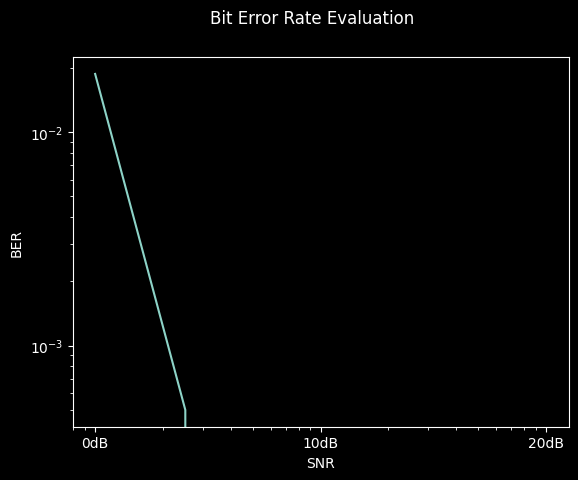

In [6]:
_ = result.plot()
plt.show()